In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Getting setup

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict, Tuple
import pandas as pd
import shutil
import os
import random

try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

try:
    from torchinfo import summary
except:
    print("[INFO] Installing torchinfo .")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine, utils
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine, utils
    from helper_functions import download_data, set_seeds, plot_loss_curves

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.7 MB/s eta 0:

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting data

In [4]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Creating an EffNetB2 feature extractor

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 99.0MB/s]


In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(
  nn.Dropout(p=0.3, inplace=True),
  nn.Linear(in_features=1408,
            out_features=3))

Creating a function to make an EffNetB2 feature extractor

In [9]:
def create_effnetb2_model(num_classes:int=3, seed:int=13):

  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=13)

In [11]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Creating DataLoaders for EffNetB2

In [12]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d4e5f759360>,
 ['pizza', 'steak', 'sushi'])

Training EffNetB2 feature extractor

In [13]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds(13)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=8,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9324 | train_acc: 0.6646 | test_loss: 0.7017 | test_acc: 0.9313
Epoch: 2 | train_loss: 0.7285 | train_acc: 0.7896 | test_loss: 0.5746 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.5442 | train_acc: 0.9021 | test_loss: 0.4975 | test_acc: 0.9284
Epoch: 4 | train_loss: 0.4766 | train_acc: 0.9125 | test_loss: 0.4452 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4605 | train_acc: 0.8688 | test_loss: 0.4031 | test_acc: 0.9256
Epoch: 6 | train_loss: 0.4477 | train_acc: 0.8542 | test_loss: 0.3784 | test_acc: 0.9437
Epoch: 7 | train_loss: 0.3405 | train_acc: 0.9146 | test_loss: 0.3448 | test_acc: 0.9381
Epoch: 8 | train_loss: 0.3261 | train_acc: 0.9313 | test_loss: 0.3217 | test_acc: 0.9563


Inspecting EffNetB2 loss curves

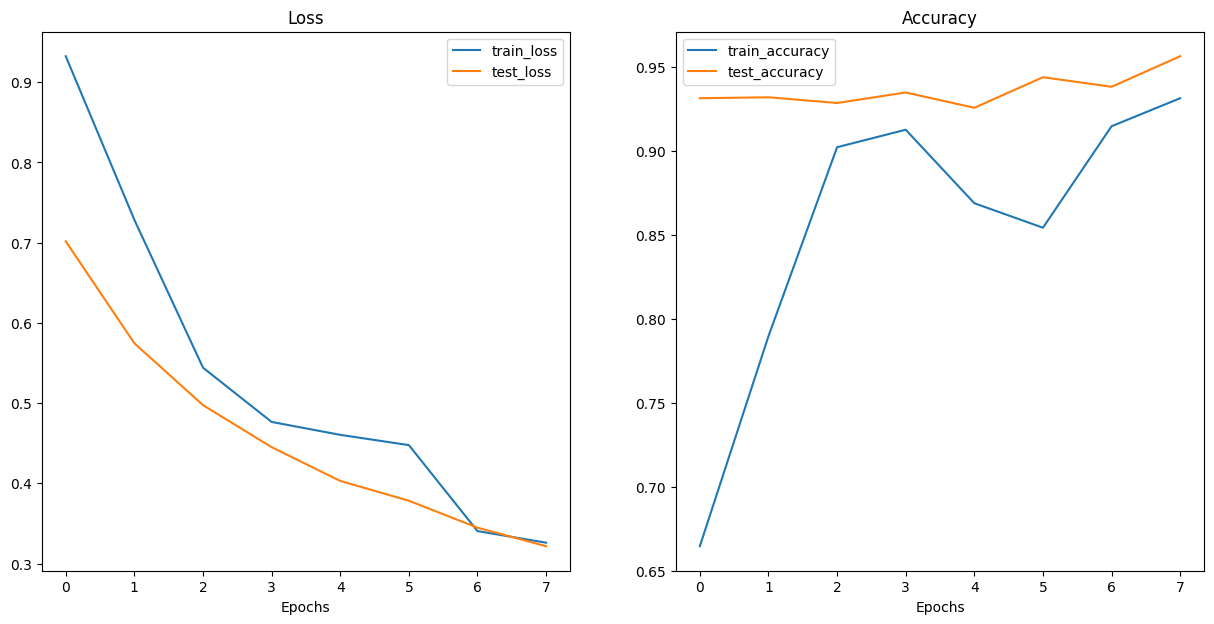

In [14]:
plot_loss_curves(effnetb2_results)

Saving EffNetB2 feature extractor

In [15]:
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


Checking the size of EffNetB2 feature extractor

In [16]:
path = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")
effnetb2_model_size = path.stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


Collecting EffNetB2 feature extractor stats

In [17]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
effnetb2_stats = {"test_loss": round(effnetb2_results["test_loss"][-1], 2),
                  "test_acc": round(effnetb2_results["test_acc"][-1], 2),
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.32,
 'test_acc': 0.96,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## Creating a ViT feature extractor

In [19]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
def create_vit_model(num_classes:int=3, seed:int=13):

  """Creates a ViT-B/16 feature extractor model and transforms.

  Args:
    num_classes (int, optional): number of target classes. Defaults to 3.
    seed (int, optional): random seed value for output layer. Defaults to 42.

  Returns:
    model (torch.nn.Module): ViT-B/16 feature extractor model.
    transforms (torchvision.transforms): ViT-B/16 image transforms.
  """

  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

  return model, transforms

In [21]:
vit, vit_transforms = create_vit_model(num_classes=3, seed=42)
vit, vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 68.9MB/s]


(VisionTransformer(
   (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
   (encoder): Encoder(
     (dropout): Dropout(p=0.0, inplace=False)
     (layers): Sequential(
       (encoder_layer_0): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (self_attention): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
         (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (0): Linear(in_features=768, out_features=3072, bias=True)
           (1): GELU(approximate='none')
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=3072, out_features=768, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (encoder_layer_1): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine

In [22]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

Create DataLoaders for ViT

In [23]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

train_dataloader_vit, test_dataloader_vit, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d4e5f832860>,
 ['pizza', 'steak', 'sushi'])

Training ViT feature extractor

In [24]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds(13)
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=8,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6139 | train_acc: 0.7979 | test_loss: 0.2623 | test_acc: 0.9443
Epoch: 2 | train_loss: 0.2170 | train_acc: 0.9437 | test_loss: 0.1384 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.1545 | train_acc: 0.9542 | test_loss: 0.1075 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1212 | train_acc: 0.9604 | test_loss: 0.0949 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1034 | train_acc: 0.9688 | test_loss: 0.0849 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0868 | train_acc: 0.9750 | test_loss: 0.0783 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.0821 | train_acc: 0.9792 | test_loss: 0.0766 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0653 | train_acc: 0.9875 | test_loss: 0.0709 | test_acc: 0.9722


Inspecting ViT loss curves

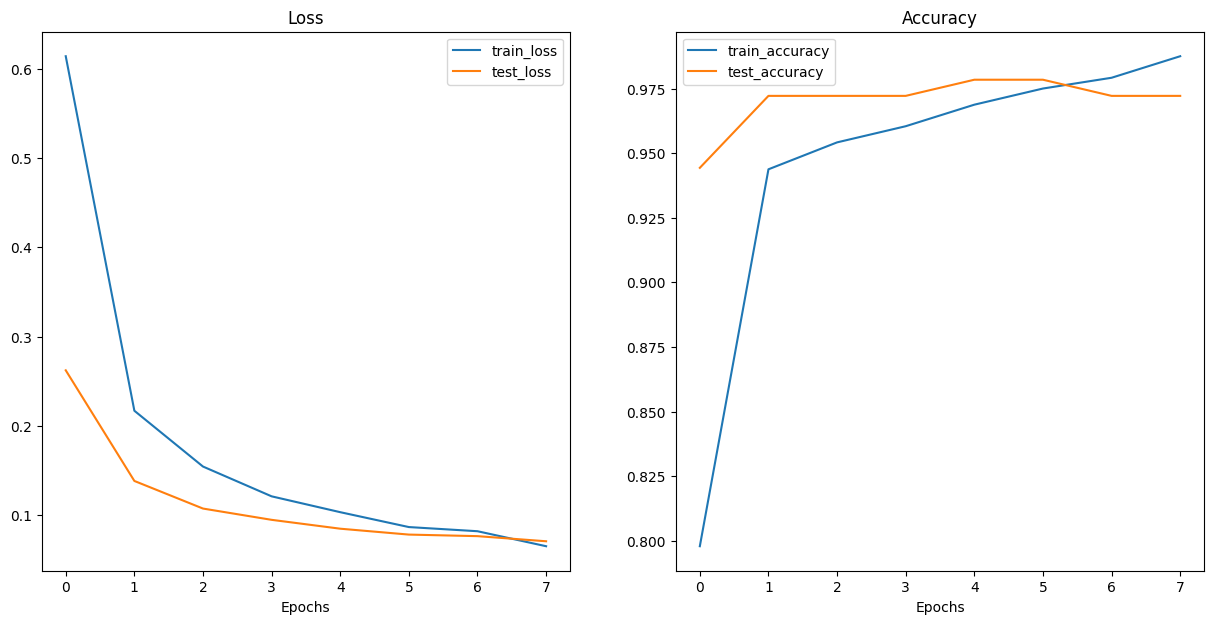

In [25]:
plot_loss_curves(vit_results)

Saving ViT feature extractor

In [26]:
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


Checking the size of ViT feature extractor

In [27]:
path2 = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")
vit_model_size = path2.stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Collecting ViT feature extractor stats

In [28]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [29]:
vit_stats = {"test_loss": round(vit_results["test_loss"][-1], 2),
             "test_acc": round(vit_results["test_acc"][-1], 2),
             "number_of_parameters": vit_total_params,
             "model_size (MB)": vit_model_size}

vit_stats

{'test_loss': 0.07,
 'test_acc': 0.97,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## Making predictions with our trained models and timing them

In [30]:
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg')]

Creating a function to make predictions across the test dataset

In [31]:
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  for path in tqdm(paths):

    pred_dict = {}

    pred_dict["image_path"] = path
    pred_dict["class_name"] = path.parent.stem

    start_time = timer()

    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = class_names[pred_label.cpu()]

      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    pred_dict["correct"] = pred_dict["class_name"] == pred_dict["pred_class"]

    pred_list.append(pred_dict)

  return pred_list

Making and timing predictions with EffNetB2

In [32]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [33]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8605,
  'pred_class': 'steak',
  'time_for_pred': 0.3185,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7743,
  'pred_class': 'steak',
  'time_for_pred': 0.1287,
  'correct': True}]

In [34]:
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.8605,steak,0.3185,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7743,steak,0.1287,True
2,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.8079,steak,0.1323,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9777,steak,0.1181,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6328,steak,0.1116,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7297,pizza,0.1111,True
146,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.8019,pizza,0.1184,True
147,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.8603,pizza,0.1132,True
148,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.8498,pizza,0.1130,True


In [35]:
effnetb2_test_pred_df.correct.value_counts()

True     143
False      7
Name: correct, dtype: int64

In [36]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1275 seconds


In [37]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.32,
 'test_acc': 0.96,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1275}

Making and timing predictions with ViT

In [38]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [39]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9013,
  'pred_class': 'steak',
  'time_for_pred': 1.0753,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9949,
  'pred_class': 'steak',
  'time_for_pred': 1.0247,
  'correct': True}]

In [40]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9013,steak,1.0753,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9949,steak,1.0247,True
2,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9678,steak,1.0196,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9979,steak,1.0059,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9934,steak,1.0196,True


In [41]:
vit_test_pred_df.correct.value_counts()

True     146
False      4
Name: correct, dtype: int64

In [42]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.7352 seconds


In [43]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.07,
 'test_acc': 0.97,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.7352}

## Comparing model results, prediction times and size

In [44]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]
df["accuracy(%)"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model,accuracy(%)
0,0.32,0.96,7705221,29,0.1275,EffNetB2,96.0
1,0.07,0.97,85800963,327,0.7352,ViT,97.0


In [45]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,accuracy(%)
ViT to EffNetB2 ratios,0.21875,1.010417,11.135432,11.275862,5.766275,1.010417


Visualizing the speed vs. performance tradeoff

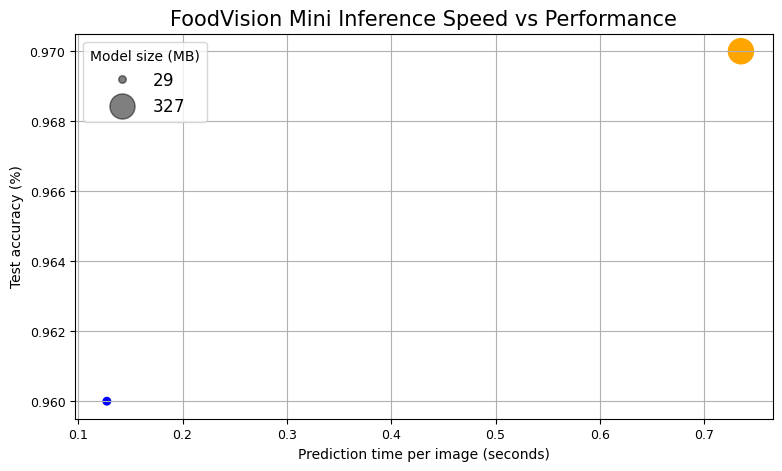

In [46]:
fig, ax = plt.subplots(figsize=(9, 5))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=15)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=10)
ax.set_ylabel("Test accuracy (%)", fontsize=10)
ax.tick_params(axis='both', labelsize=9)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row["model"], xy=(row["time_per_pred_cpu"]+0.06, row["test_acc"]+0.03), size=10)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              # loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("data/foodvision-mini-inference-speed-vs-performance.jpg")

plt.show()

# Creating a Gradio demo

In [47]:
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.47.1


Creating a function to map our inputs and outputs

In [48]:
effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [49]:
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)
    # print(pred_probs)

  pred_labels_and_probs = {class_names[i].title(): float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 2)

  return pred_labels_and_probs, pred_time

In [50]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/2948087.jpg

Prediction label and probability dictionary: 
{'Pizza': 0.15979644656181335, 'Steak': 0.11912300437688828, 'Sushi': 0.7210806012153625}
Prediction time: 0.12 seconds


In [51]:
# m_image_path = random.sample(test_data_paths, k=1)[0]
# m_image_path

Creating a list of example images

In [52]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/670345.jpg']]

Building a Gradio interface

In [53]:
title = "FoodVision Mini 🍕🥩🍣"
description = "Utilizing EfficientNetB2 feature extractor CV model classifying images of food: Pizza, Steak or Sushi."
article = "© Amuni Pelumi https://www.amunipelumi.com/"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b9ec59af55a8678764.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Turning FoodVision Mini Gradio Demo into a deployable app

In [54]:

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

In [55]:
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [56]:
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

In [57]:
effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
  shutil.move(src=effnetb2_foodvision_mini_model_path, dst=effnetb2_foodvision_mini_model_destination)
  print(f"[INFO] Model move complete.")

except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [58]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, seed:int=42):

  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [59]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ["pizza", "steak", "sushi"]

effnetb2, effnetb2_transforms = create_effnetb2_model(len(class_names))

effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """

  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  pred_labels_and_probs = {class_names[i].title(): float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 2)

  return pred_labels_and_probs, pred_time


title = "FoodVision Mini 🍕🥩🍣"
description = "Utilizing EfficientNetB2 CV model classifying images of food: Pizza, Steak or Sushi."
article = "© Amuni Pelumi https://www.amunipelumi.com/"

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction Time (S)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing demos/foodvision_mini/app.py


In [60]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.47.1

Writing demos/foodvision_mini/requirements.txt


# Deploying FoodVision Mini app to HuggingFace Spaces

In [61]:
!ls demos/foodvision_mini

app.py
examples
model.py
pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
requirements.txt


In [62]:
# !cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

In [63]:
# try:
#     from google.colab import files
#     files.download("demos/foodvision_mini.zip")
# except:
#     print("Manually download.")

## Download total package

In [68]:
if Path("foodvision-mini//").exists():
  shutil.rmtree(Path("foodvision-mini/"))
  Path("foodvision-mini/").mkdir(parents=True, exist_ok=True)
else:
  Path("foodvision-mini/").mkdir(parents=True, exist_ok=True)

In [69]:
shutil.copytree(src="data/", dst="foodvision-mini/data/")
shutil.copytree(src="demos/", dst="foodvision-mini/gradio-demo/")
shutil.copytree(src="going_modular/", dst="foodvision-mini/modular/")
shutil.copy2(src="helper_functions.py", dst="foodvision-mini/modular/assist.py")
shutil.copy2(src="drive/MyDrive/Colab Notebooks/foodvision_mini.ipynb", dst="foodvision-mini/foodvision_mini.ipynb")

'foodvision-mini/foodvision_mini.ipynb'

In [66]:
!cd foodvision-mini && zip -r foodvision-mini.zip * -x "*.pyc" "*__pycache__*" "*ipynb_checkpoints*"

  adding: data/ (stored 0%)
  adding: data/foodvision-mini-inference-speed-vs-performance.jpg (deflated 46%)
  adding: data/pizza_steak_sushi_20_percent/ (stored 0%)
  adding: data/pizza_steak_sushi_20_percent/test/ (stored 0%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/ (stored 0%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/552171.jpg (deflated 11%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg (deflated 1%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/730464.jpg (deflated 0%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/289822.jpg (deflated 0%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg (deflated 0%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/670345.jpg (deflated 0%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg (deflated 1%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg (deflated 1%)
  adding: data/pizza_steak_sushi_20_percent/test/steak/2061

In [67]:
try:
    from google.colab import files
    files.download("foodvision-mini.zip")
except:
    print("Manually download.")

Manually download.
